In [21]:
import sys
sys.path.append("../")

In [22]:
from datetime import datetime
from functools import partial
from matplotlib.dates import DateFormatter
from ta import add_all_ta_features
from ta.utils import dropna
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
keras.config.enable_unsafe_deserialization()

from draw_image_utils import draw_prediction

In [23]:
symbol_mapping = {
    "CTG": {
        "dataset_folder": "ctg_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend",
        "freq_of_date": "B"
    },
    "FPT": {
        "dataset_folder": "fpt_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend",
        "freq_of_date": "B"
    },
    "TCB": {
        "dataset_folder": "tcb_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend",
        "freq_of_date": "B"
    },
    "VN30": {
        "dataset_folder": "vn30_with_ema_macd_trend",
        "model_name": "channels_to_time_step_attention_ema_macd_trend_1_1_1_1_1_1",
        "freq_of_date": "B"
    },
    # "BTC": {
    #     "dataset_folder": "btc_with_ema_macd_trend",
    #     "model_name": "model_5_biLSTM_ema_macd_trend",
    #     "freq_of_date": "D"
    # },
    "BTC": {
        "dataset_folder": "btc_with_ema_macd_trend",
        "model_name": "channels_to_time_step_attention_ema_macd_trend",
        "freq_of_date": "D"
    },
    "COCA_COLA": {
        "dataset_folder": "coca_cola_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend_1_1_1",
        "freq_of_date": "D"
    },
    "ETH": {
        "dataset_folder": "eth_with_ema_macd_trend",
        "model_name": "channels_to_time_step_attention_ema_macd_trend_1",
        "freq_of_date": "D"
    },
    "APPLE": {
        "dataset_folder": "apple_with_ema_macd_trend",
        "model_name": "model_5_biLSTM_ema_macd_trend_1_1",
        "freq_of_date": "D"
    },
}

In [24]:
symbol = input("Symbol = ").strip().upper()
dataset_folder_name = symbol_mapping[symbol]["dataset_folder"]
model_name = symbol_mapping[symbol]["model_name"]
dataset_folder = f"../dataset/{dataset_folder_name}"
index_of_image_input = 3
batch_size = 100
freq_of_date = symbol_mapping[symbol]["freq_of_date"] # B or D

config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [25]:
function_transform_origin = get_origin_transform_function(
    os.path.join(
        os.path.abspath(f"{dataset_folder}/model_save/{model_name}"),
        "config_and_loss.json"
    )
)
path_of_model = f"{dataset_folder}/model_save/{model_name}/{model_name}.keras"
model = keras.models.load_model(os.path.abspath(path_of_model))


In [26]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)


In [27]:
image_shape = get_image_shape(dataset_test, index_of_image_input)

In [28]:
config_of_continue_learning_folder = read_config(dataset_folder)
file_csv_path = config_of_continue_learning_folder["file_csv"]
df_get_from_api = pd.read_csv(file_csv_path)
df_get_from_api["Date"] = pd.to_datetime(df_get_from_api["Date"])

In [29]:
def date_generator(date_i):
    index_of_date = get_date_index(df_get_from_api, date_i)
    total_days = previous_days + 1 + next_days + days_result
    all_dates = df_get_from_api[index_of_date:index_of_date + total_days]["Date"].dt.date
    total_date_reals = len(all_dates)
    dates_real = all_dates
    if len(all_dates) < total_days:
        all_dates = pd.date_range(start=str(date_i), periods=total_days, freq=freq_of_date)
    return list(all_dates), total_date_reals

In [30]:
dataset_test_1 = dataset_test
dataset_test_2 = dataset_test_1.batch(batch_size)
transform_function = partial(function_transform_origin, days_result)
dataset_test_3 = dataset_test_2.map(transform_function)

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 287, 287,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 286, 286,  │        104 │ image_input[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 285, 285,  │         99 │ conv2d[0][0]      │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 142, 142,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 3, 142,    │          0 │ max_pooling2d[0]… │
│                     │ 142)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ema_9_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ macd_history_input  │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trend_type_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 3, 20164)  │          0 │ permute[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │         24 │ ema_9_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │         24 │ macd_history_inp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         16 │ trend_type_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 3, 64)     │  1,290,560 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 3, 8)      │          0 │ dense_1[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 3, 8)      │          0 │ dense_2[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 3, 8)      │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 3, 64)     │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3, 88)     │          0 │ repeat_vector_1[

 Total params: 5,679,244 (21.66 MB)

 Trainable params: 1,893,081 (7.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,786,163 (14.44 MB)

In [32]:
loss = model.evaluate(dataset_test_3)

d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step - loss: 4.8806 - mae: 1.5237 - mse: 4.8806


In [33]:
loss

[4.880600929260254, 1.523748517036438, 4.880600929260254]

In [34]:
prediction_for_test = model.predict(dataset_test_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


In [35]:
print(prediction_for_test)

[[[ 5.34987867e-01  3.84310633e-02]
  [-3.79591957e-02 -3.82021874e-01]
  [-3.48830581e-01 -3.83242726e-01]]

 [[ 1.14052415e+00  7.79532850e-01]
  [ 4.58543807e-01  2.25656286e-01]
  [ 2.57485420e-01  2.84598053e-01]]

 [[ 8.83826911e-01 -1.73183233e-02]
  [ 9.84347105e-01  8.70154738e-01]
  [ 7.48396516e-01  9.17644501e-01]]

 [[ 5.74548244e-01 -1.87807500e-01]
  [ 7.51308858e-01  5.76862216e-01]
  [ 7.10781336e-01  8.31921577e-01]]

 [[-3.13927412e+00 -1.62190640e+00]
  [-8.10650647e-01 -7.82870591e-01]
  [-3.86038125e-01 -3.35530996e-01]]

 [[ 7.09818363e-01 -2.12897450e-01]
  [ 1.13224244e+00  1.03291297e+00]
  [ 8.48957717e-01  1.02504718e+00]]

 [[ 1.44855797e+00  1.69951737e+00]
  [ 5.52422404e-01  4.02688622e-01]
  [ 3.66032422e-01  3.92232060e-01]]

 [[-8.03625345e-01 -8.11134934e-01]
  [-2.83533156e-01 -4.82636333e-01]
  [-2.29819477e-01 -3.40245306e-01]]

 [[-3.90255833e+00 -1.45520294e+00]
  [-7.08349705e-01 -7.94018865e-01]
  [-2.16036588e-01 -2.18889266e-01]]

 [[ 1.3956

In [36]:
len(prediction_for_test)

62

In [37]:
all_dates = unwrap_dataset_at_index(dataset_test, 5, to_numpy=True, map_function=lambda date: str(datetime.fromisoformat(date.decode("utf-8")).date()))
trend_dataset_test_2 = unwrap_dataset_at_index(unwrap_dataset_at_index(dataset_test_2, 2, batch=True, to_numpy=True), 0)
_4_prices_of_all_days_dataset_test_2 = unwrap_dataset_at_index(dataset_test_2, 4, batch=True, to_numpy=True)
image_input_dataset_test_2 = unwrap_dataset_at_index(dataset_test_2, 3, batch=True, to_numpy=True)
real_percent_last_days_result_dataset_test_3 = unwrap_dataset_at_index(dataset_test_3, 1, batch=True, to_numpy=True) 

In [38]:
mapping_trend_type = {
    1: "GROUP_BULL",
    -1: "GROUP_BEAR",
    0: "GROUP_SIZEWAY",
}

real: [[1.41808545 0.        ]
 [0.91439838 3.20178249]
 [0.13387573 0.91439838]]
prediction: [[ 0.8838269  -0.01731832]
 [ 0.9843471   0.87015474]
 [ 0.7483965   0.9176445 ]]


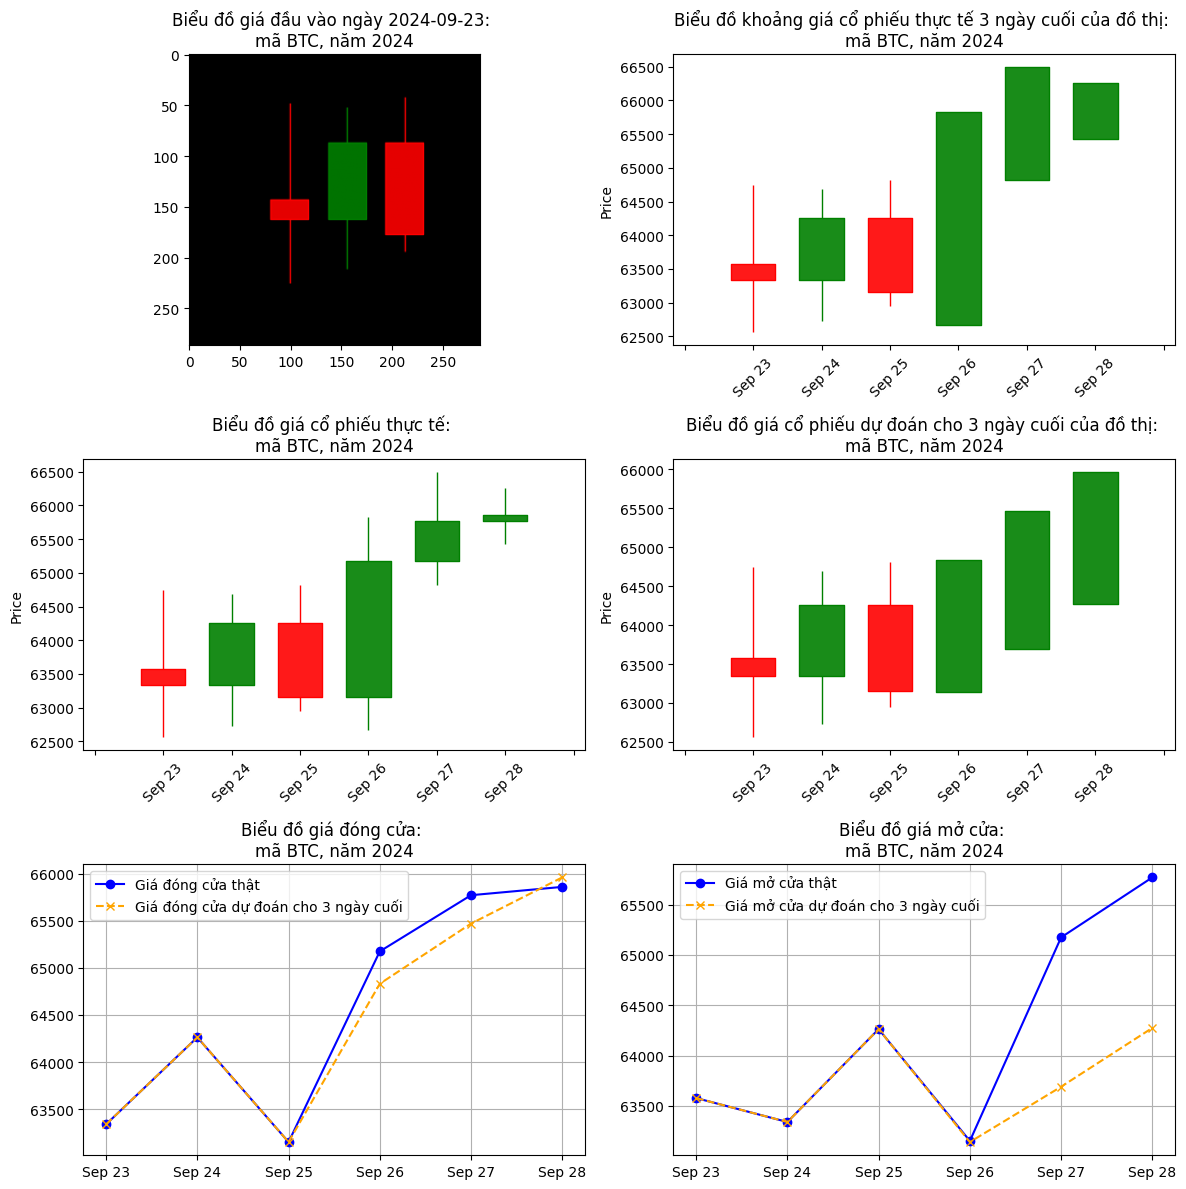

In [39]:
index = 2
print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
print(f"prediction: {prediction_for_test[index]}")
type_of_output = "open_and_close"
draw_prediction(
    image_input_dataset_test_2[index], 
    _4_prices_of_all_days_dataset_test_2[index], 
    all_dates[index],
    prediction_for_test[index], 
    show_x_orginal_candle=True,
    show_prediction_candle=True, 
    show_original_candle=True,
    show_close_compare=True,
    show_open_compare=True,
    type_of_output=type_of_output,
    draw_beside=True,
    print_image=True,
    extend_real=True,
    date_generator=date_generator,
    symbol=symbol)

In [44]:
# index = 0
is_print_all = input("Print all? (y/n): ").lower()[0] == "y"
type_of_output = "open_and_close"
if is_print_all:
    group = input("Group to print? (bull/bear/sizeway/all) ").strip().lower()
    is_extend_real = input("Extend real? (y/n): ").strip().lower()[0] == "y"
    if "bull" in group:
        group = "GROUP_BULL"
    elif "bear" in group:
        group = "GROUP_BEAR"
    elif "sizeway" in group:
        group = "GROUP_SIZEWAY"
    elif len(group) == 0 or "all" in group:
        group = None
        
    folder_name = f"{model_name}"
    if group is not None:
        folder_name += f"/{group}"
    
    if is_extend_real:
        folder_name = f"extend_real_{folder_name}"
    folder_save_image_predict = f"{dataset_folder}/output_prediction_image/{folder_name}"
    
    os.makedirs(folder_save_image_predict, exist_ok=False)
    
    date_printed = set()
    for index in range(len(_4_prices_of_all_days_dataset_test_2)):
        if index % 10 == 0:
            print(f"---------------- Save: {index}/{len(_4_prices_of_all_days_dataset_test_2)} images")
        print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
        print(f"prediction: {prediction_for_test[index]}")
        date = all_dates[index]
        if date in date_printed:
            continue
        else:
            date_printed.add(date)
        
        trend_type = mapping_trend_type[trend_dataset_test_2[index]]
        
        if group is not None:
            if trend_type != group:
                continue
        
        draw_prediction(
            image_input_dataset_test_2[index], 
            _4_prices_of_all_days_dataset_test_2[index], 
            date,
            prediction_for_test[index], 
            show_x_orginal_candle=True,
            show_prediction_candle=True, 
            show_original_candle=True,
            show_close_compare=True,
            show_open_compare=True,
            type_of_output=type_of_output,
            draw_beside=True,
            save_image=f"{folder_save_image_predict}/{date}_{trend_type}_predict.png",
            print_image=False,
            extend_real=is_extend_real,
            date_generator=date_generator,
            symbol=symbol)

---------------- Save: 0/62 images
real: [[ 0.          3.20081841]
 [-0.83386917 -1.43520006]
 [-1.43520006 -1.55249247]]
prediction: [[ 0.53498787  0.03843106]
 [-0.0379592  -0.38202187]
 [-0.34883058 -0.38324273]]
real: [[1.93016063 2.39083834]
 [0.40201442 1.93016063]
 [0.23404674 0.40201442]]
prediction: [[1.1405241  0.77953285]
 [0.4585438  0.22565629]
 [0.25748542 0.28459805]]
real: [[1.41808545 0.        ]
 [0.91439838 3.20178249]
 [0.13387573 0.91439838]]
prediction: [[ 0.8838269  -0.01731832]
 [ 0.9843471   0.87015474]
 [ 0.7483965   0.9176445 ]]
real: [[ 0.88266499  0.        ]
 [ 0.         -1.46318991]
 [-2.32644315  0.        ]]
prediction: [[ 0.57454824 -0.1878075 ]
 [ 0.75130886  0.5768622 ]
 [ 0.71078134  0.8319216 ]]
real: [[-1.62105261  0.        ]
 [ 1.38457583  0.59134914]
 [ 2.8527808   1.38457583]]
prediction: [[-3.1392741  -1.6219064 ]
 [-0.81065065 -0.7828706 ]
 [-0.38603812 -0.335531  ]]
real: [[ 0.72683657  0.        ]
 [ 0.          3.71616534]
 [-0.52005842

In [45]:
folder_save_image_predict

'../dataset/btc_with_ema_macd_trend/output_prediction_image/extend_real_channels_to_time_step_attention_ema_macd_trend/GROUP_SIZEWAY'